# Stability of feature selection with regularized methods

In this tutorial, we will explore the concept of _'stability'_ of a feature selection algorithm. The term here refers to the robustness of its feature preferences, with respect to data sampling.  We can say that feature has high stability if multiple feature selection repetitions “agree” that this feature is important and low stability when multiple feature selection processes  “disagree” that this feature is important.  

Stability is not always easy to achieve, especially in the real world data, but it is extremely important to analyse when selecting features. Having a stable set of features is a proxy for _reproducible research_, especially in the biomedical field (e.g. which genes that algorithm selected are likely to be a data artefact and not a real clinical signal worth pursuing further?)

______________________________

Let's start! As always, we first load the packages we need:

**TBA**: Reference to Noguiera tutorial/paper!

In [91]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics._scorer import make_scorer
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import stability as st
from utils_ import getBootstrapSample
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data loading

Here we just load the data we preprocessed in the data_preprocessing.ipynb. Recall, this is the gene expression dataset with... **TBA**

**NOTE** - currently the results show the breast cancer dataset as they are much better to showcase what we want!

In [92]:
# data = pd.read_csv("./data/tomatos_with_targets.txt", index_col=0)
# data.head()
data = pd.read_csv("./data/breast_cancer.csv")
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Setup

...If tomato dataset: 
We extracted multiple targets from the dataset and here we want to choose which one we decide to model and we discard the rest.

In [93]:
# Choose the target
#target = 'species'
target = 'target'

# Targets
#potential_targets = ['species','position','tissue','root']
potential_targets = []
# Remove other potential targets
drop = list(set(potential_targets) - set([target]))
data_model = data.drop(columns = drop, axis = 1)
data_model.head()

# Save only feature column names:
feature_columns =  data_model.drop(columns=[target], axis=1).columns

# Save X and y separately
X = data_model.drop(target, axis=1)
y = data_model[target]

Encode the labels: our labels are categorical and we need to encode them to have integer values. 

Scale the data: Regression models benefit from scaling the data.

In [94]:
# Encode labels if it is classification
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(np.unique(data_model[target], return_counts=True))
print(np.unique(y, return_counts=True))
#Scale the data
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

(array([0, 1]), array([212, 357]))
(array([0, 1]), array([212, 357]))


In [95]:
X_transformed[:5,:5]

array([[ 1.09706398, -2.07333501,  1.26993369,  0.9843749 ,  1.56846633],
       [ 1.82982061, -0.35363241,  1.68595471,  1.90870825, -0.82696245],
       [ 1.57988811,  0.45618695,  1.56650313,  1.55888363,  0.94221044],
       [-0.76890929,  0.25373211, -0.59268717, -0.76446379,  3.28355348],
       [ 1.75029663, -1.15181643,  1.77657315,  1.82622928,  0.28037183]])

## Modeling without taking stability into account
Elastic net regression on the full dataset - How it is usually done? Usually, the lambda maximizing the accuracy is taken,...

In [96]:
# Just for now..can't get elastic net to run w/o the convergence error 
import warnings
warnings.filterwarnings('ignore')

Define the model:

In [97]:
# model = LogisticRegression(penalty='l1', solver='liblinear',max_iter=300)
# model_name = 'lasso'
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=1000)
model_name = 'elasticnet'

Define the grid for the hyperparameter search:

In [98]:
num_lambdas = 10 # We will test 10 parameters
lambdas = np.linspace(-2,0,num_lambdas).astype(float)
lambdas=np.power(10,lambdas)
hyper_grid = {'C': lambdas}
hyper_grid


{'C': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
        0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])}

Find the optimal parameter for Lasso:

In [99]:
# Define a grid search with 10-fold CV and fit 
gridsearch_classifier = GridSearchCV(model, hyper_grid, cv=StratifiedKFold(n_splits=4), verbose=1, scoring='accuracy')
gridsearch_classifier.fit(X_transformed, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                          penalty='elasticnet', solver='saga'),
             param_grid={'C': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])},
             scoring='accuracy', verbose=1)

In [100]:
gridsearch_classifier.cv_results_

{'mean_fit_time': array([0.00666076, 0.0070793 , 0.00876832, 0.01258868, 0.01990551,
        0.02582604, 0.03544575, 0.04977745, 0.06696051, 0.09759128]),
 'std_fit_time': array([0.00099399, 0.00041851, 0.00030001, 0.00031306, 0.00083134,
        0.00178889, 0.00258902, 0.00293165, 0.00669359, 0.00936451]),
 'mean_score_time': array([0.00055945, 0.00098884, 0.00050646, 0.00048637, 0.00051475,
        0.00048321, 0.000521  , 0.00052279, 0.00054306, 0.00056416]),
 'std_score_time': array([4.42549134e-05, 5.94136289e-04, 5.14173242e-05, 4.97127036e-05,
        2.75190197e-05, 2.37549001e-05, 3.80471440e-05, 3.29657874e-05,
        4.26673928e-05, 2.46087793e-05]),
 'param_C': masked_array(data=[0.01, 0.016681005372000592, 0.027825594022071243,
                    0.046415888336127774, 0.0774263682681127,
                    0.1291549665014884, 0.21544346900318834,
                    0.3593813663804626, 0.5994842503189409, 1.0],
              mask=[False, False, False, False, False, False

In [101]:
print(gridsearch_classifier.cv_results_['params'])
print(f"Average accuracy: {round(np.mean(gridsearch_classifier.cv_results_['mean_test_score'])*100,2)}%")

[{'C': 0.01}, {'C': 0.016681005372000592}, {'C': 0.027825594022071243}, {'C': 0.046415888336127774}, {'C': 0.0774263682681127}, {'C': 0.1291549665014884}, {'C': 0.21544346900318834}, {'C': 0.3593813663804626}, {'C': 0.5994842503189409}, {'C': 1.0}]
Average accuracy: 96.03%


In [102]:
C = gridsearch_classifier.best_params_
print(f"Chosen parameter {C}")

Chosen parameter {'C': 0.5994842503189409}


## Stability analysis
### Optimizing Stability and Accuracy of Regularized Methods

In [103]:
#num_lambdas=10
#lambdas=np.linspace(-3,-1,num_lambdas)
#lambdas=np.power(10,lambdas) 
print(lambdas)
M = 10
d = X.shape[1]

[0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]


In [104]:
Z=np.zeros((num_lambdas,M,d),dtype=np.int8)
errors=np.zeros((M,num_lambdas))
stabilities=np.zeros(num_lambdas)
errStab=np.zeros(num_lambdas)
numFeatSelected=np.zeros((M,num_lambdas),dtype=np.int32)

We apply L1-logistic regression with different regularizing parameters lambda on M bootstrap samples of the data using the scikit-learn package. We report the stability as given in [1] and the average out-of-bag (OOB) error over the M repeats.



In [105]:
from utils_ import getBootstrapSample

In [106]:
## for each repeat
for i in tqdm(range(M)):
    newData=getBootstrapSample(np.asarray(X_transformed),np.asarray(y), random_state=(i+1)*10+1234) ## we get a bootstrap sample
    for k in range(num_lambdas):
        logistic = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C=lambdas[k], max_iter=1000, random_state=(i+1)*10+12345)
        logistic.fit(newData['bootData'],newData['bootLabels'])  ## we fit the coefficients 
        Z[k,i,:]=sum(logistic.coef_!=0)
        numFeatSelected[i,k]=sum(sum(logistic.coef_!=0))
        predLabels=logistic.predict(newData['OOBData'])
        errors[i,k]=1-accuracy_score(newData['OOBLabels'], predLabels)
meanError=np.mean(errors,0)
#errCI=norm.ppf(1-alpha/2)*(np.std(errors,0))/math.sqrt(M)

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


To better understand what is saved in each object, let's check their size and how the results look like:

In [107]:
print(f'Errors {errors.shape}')
print(f'numfeatselected {numFeatSelected.shape}')
print(f'Z {Z.shape}')

Errors (10, 10)
numfeatselected (10, 10)
Z (10, 10, 30)


In [108]:
Z_dict = {}
for i in range(Z.shape[0]):
    Z_dict[lambdas[i]] = pd.DataFrame(Z[i, :,:], columns=X.columns)

In [109]:
index = 0
print(f'For lambda = {lambdas[index]}, results look like follows:')
Z_dict[lambdas[index]].head()

For lambda = 0.01, results look like follows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,0,1,1,0,0
1,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
2,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
3,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,0,1,1,0,0
4,1,0,1,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,0


Lambda vs. number of features chosen:

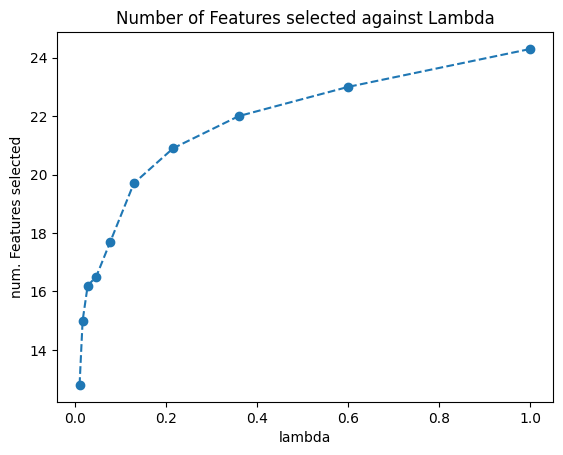

In [110]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(numFeatSelected,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('num. Features selected')
plt.title('Number of Features selected against Lambda')
plt.show()

As we expect, the number of features selected decreases as we increase the regularization.
Let us now plot the average OOB error against lambda

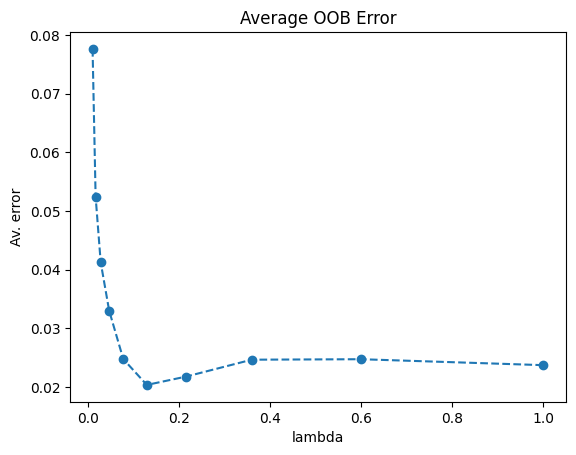

In [111]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(errors,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Av. error')
plt.title('Average OOB Error')
plt.show()

In [112]:
for k in range(num_lambdas):
    res=st.confidenceIntervals(Z[k,:,:],alpha=0.05) ## we get the confidence intervals using the stability package
    stabilities[k]=res['stability']
    errStab[k]=stabilities[k]-res['lower']

In [113]:
stabilities

array([0.87887597, 0.86962963, 0.90159241, 0.85484474, 0.82392479,
       0.7322294 , 0.7633945 , 0.66666667, 0.46583851, 0.3237552 ])

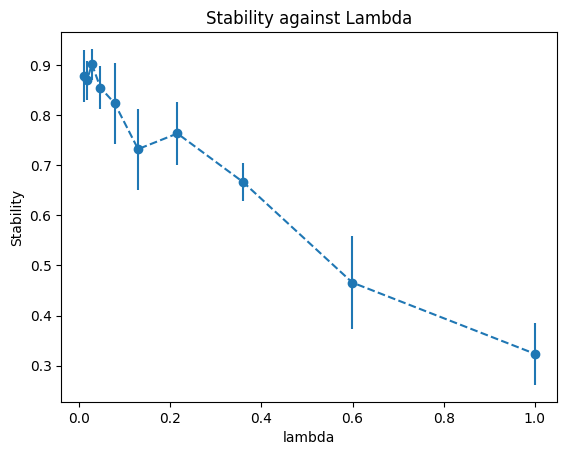

In [114]:
plt.close()
plt.figure()
plt.errorbar(lambdas,stabilities,yerr=errStab,marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Stability')
plt.title('Stability against Lambda')
plt.show()

In [115]:
best_index = np.nanargmax(stabilities)
gridsearch_index = np.where(lambdas == gridsearch_classifier.best_params_['C'])[0][0]

print(f"--- lambda = {lambdas[best_index]} ---")
print(f'Stability is maximal = {round(stabilities[best_index]*100,2)}%. \nAverage Number of features selected for this lambda across {M} iterations is {np.mean(numFeatSelected[best_index])}. \nAverage OOB error is {np.mean(errors[best_index])}')
print('\n')
print(f"--- lambda (grid search) = {gridsearch_classifier.best_params_['C']} ---")
print(f'Stability = {round(stabilities[gridsearch_index]*100,2)}%. \nAverage Number of features selected for this lambda across {M} iterations is {np.mean(numFeatSelected[gridsearch_index])}. \nAverage OOB error is {np.mean(errors[gridsearch_index])}')


--- lambda = 0.027825594022071243 ---
Stability is maximal = 90.16%. 
Average Number of features selected for this lambda across 10 iterations is 20.1. 
Average OOB error is 0.0469387755102041


--- lambda (grid search) = 0.5994842503189409 ---
Stability = 46.58%. 
Average Number of features selected for this lambda across 10 iterations is 17.2. 
Average OOB error is 0.031455399061032875


As we can see from these figures, the value of the regularizing parameter that yields the maximal stability (out of the 10 regularizing parameters chosen) is not the one yielding the minimum error. Here, a trade-off between error and stability needs to chosen.
Nevertheless, we can see that making a small sacrife in terms of accuracy can largely improve stability.

## Potential next steps

Now that we analysed which hyperparameter(s) might be good for fitting our model and what is the effect of it on the stability, we can choose how to proceed with the analysis. This, of course, depends on our goal and we will cover two possible options:

1. You wish to have a trained model with coefficients that you want to reuse on the unseen data
2. You wish to decide on the final reduced set of features that will enter some other statistical analysis (e.g. the set of chosen genes will be selected for further inspection to seach for clinical signal or a doctor should pay extra attention to selected variables when assessing the patient.)

### Option 1 - training the model by using newly gained knowledge

Now that we know much more about the effect of the regularization parameter on both accuracy and stability of the model and feature selection, we need to decide whether we are ready to accept the aforementioned trade-off between accuracy and stability, i.e., decide if we want to lose a bit of accuracy for the sake of more stable model.
...TBA...

In [116]:
# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(
#     data_model.drop(columns=[target], axis=1),
#     data_model[target], stratify = data_model[target],
#     test_size=0.2,
#     random_state=444)

# # Train - validation split
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train,
#     y_train, stratify = y_train,
#     test_size=0.2,
#     random_state=234)

# print(f"X train: {X_train.shape}, X test: {X_test.shape}, X valid: {X_valid.shape}")
# print(f"y train: {y_train.shape}, y test: {y_test.shape}, y valid: {y_valid.shape}")
# print(f"y train values: {np.unique(y_train, return_counts=True)}")
# print(f"y test values: {np.unique(y_test, return_counts=True)}")

# # Encode labels
# encoder = LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.transform(y_test)

# print("Encoding check:")
# print(np.unique(y_train, return_counts=True))
# print(np.unique(y_test, return_counts=True))

# # Scale the data
# scaler = StandardScaler()
# X_train_transformed = scaler.fit_transform(X_train)
# X_test_transformed = scaler.transform(X_test)
# X_valid_transformed = scaler.transform(X_valid)


In [117]:
# # Define a model
# model = LogisticRegression(penalty = 'elasticnet', 
#                            solver = 'saga', 
#                            l1_ratio = 0.5, 
#                            C = lambdas[best_index], 
#                            max_iter=1000, 
#                            random_state=12345)

# model_grid = LogisticRegression(penalty = 'elasticnet', 
#                                 solver = 'saga', 
#                                 l1_ratio = 0.5, 
#                                 C = lambdas[gridsearch_index],
#                                 max_iter=1000, 
#                                 random_state=12345)

In [118]:
# oob_scorer = lambda y_test, y_pred: 1-accuracy_score(y_test, y_pred)
# my_scorer = make_scorer(oob_scorer, greater_is_better=False) # Smaller OOB error means better model

# # Run cross_val_score
# print(f"Average accuracy across 4-fold cv: {round(np.mean(cross_val_score(model, X_train_transformed, y_train, 
#                                                                           cv=4, scoring='accuracy'))*100,2)}%")

What if we fit with the grid-search index?

In [119]:
# oob_scorer = lambda y_test, y_pred: 1-accuracy_score(y_test, y_pred)
# my_scorer = make_scorer(oob_scorer, greater_is_better=False) # Smaller OOB error means better model

# # Run cross_val_score
# print(f"Average accuracy across 4-fold cv: {round(np.mean(cross_val_score(model_grid, X_train_transformed, y_train,
#                                                                           cv=4, scoring='accuracy'))*100,2)}%")


### Option 2 - selecting final set of features

Stability selector paper: 

**set of stable features** = set of all the features having a frequency of selection higher than some user defined threshold for __at least__ one of the regularizing parameteres lambda from lambdas

In [120]:
for i in range(len(lambdas)):
    Z_i = Z_dict[lambdas[i]]
    if i==0:
        count_per_feature = pd.DataFrame(Z_i.sum(axis=0), columns=['lambda_'+str(i)])
    else:
        count_per_feature = pd.concat([count_per_feature, pd.DataFrame(Z_i.sum(axis=0), columns=['lambda_'+str(i+1)])], axis=1)
count_per_feature['total'] = count_per_feature.sum(axis=1)
count_per_feature.sort_values(by='total', ascending=False, inplace=True)

In [121]:
count_per_feature

,lambda_0,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,lambda_7,lambda_8,lambda_9,lambda_10,total
worst radius,10,10,10,10,10,10,10,10,10,10,100
mean concave points,10,10,10,10,10,10,10,10,10,10,100
worst perimeter,10,10,10,10,10,10,10,10,10,10,100
worst area,10,10,10,10,10,10,10,10,10,10,100
worst concave points,10,10,10,10,10,10,10,10,10,10,100
worst concavity,10,10,10,10,10,10,10,10,10,10,100
worst texture,9,10,10,10,10,10,10,10,10,10,99
worst smoothness,8,10,10,10,10,10,10,10,10,10,98
mean concavity,10,10,10,10,9,9,10,10,10,10,98
mean area,10,10,10,10,10,10,10,10,10,8,98


In [122]:
# Set the threshold - percentage of M
threshold = int(0.9*M)
threshold

9

In [123]:
final_feature_set = []
for i in range(count_per_feature.shape[0]):
    if (count_per_feature.iloc[i,:count_per_feature.shape[1]-1] >= threshold).any() == True:
        final_feature_set.append(count_per_feature.index[i])

In [124]:
#final_feature_set = list(count_per_feature.index[np.where(count_per_feature['total'] >= threshold)[0]])
print(f"There are {len(final_feature_set)} features in the final feature set, based on a threshold of {threshold}:\n")
print(*final_feature_set, sep='\n')

There are 20 features in the final feature set, based on a threshold of 9:

worst radius
mean concave points
worst perimeter
worst area
worst concave points
worst concavity
worst texture
worst smoothness
mean concavity
mean area
mean radius
mean perimeter
worst symmetry
mean texture
radius error
perimeter error
area error
fractal dimension error
compactness error
mean fractal dimension


TODO - address overfitting!

## Other approaches to stability analysis 
Clustering and PCA?